# **Systèmes de Recherche d'Images par le Contenu - Approche Deep"**

La recherche d'images basée sur le contenu consiste à retrouver dans une base de données les images visuellement similaires à une image donnée, en se basant sur leurs caractéristiques visuelles.
Avec l’essor de l’apprentissage profond, les méthodes CBIR ont considérablement évolué. Les réseaux neuronaux permettent désormais d’extraire des descripteurs riches et discriminants, capturant à la fois des détails locaux et des informations sémantiques globales.

Dans ce projet, nous allons comparer deux approches principales pour l’extraction de features en CBIR :

1. **Réseau CNN pré-entraîné** (VGG16, ResNet50, etc) :  
   - Utilisé comme extracteur de caractéristiques.  
   - Les couches profondes fournissent des représentations hiérarchiques des images (bords, textures) à des concepts plus complexes.  

2. **Autoencodeur profond** :  
   - Apprend à encoder une image dans un code latent compact puis à la reconstruire.  
   - Le code latent est utilisé comme vecteur de descripteur
  
  **Objectifs du TP :**  

- Charger et prétraiter la base d’images fournie
- Utiliser un CNN pré-entraîné pour extraire des descripteurs  
- Construire et entraîner un autoencodeur profond
- Définir une métrique de similarité (cosine ou euclidienne)  
- Effectuer des recherches CBIR et afficher les images les plus similaires à une image requête  
- Visualiser les feature maps pour comprendre les représentations apprises par chaque type de réseau  



# **2. Importer les librairies nécessaires**

In [ ]:
import numpy as np
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import Image
import PIL.Image as Image
import torch.optim as optim

import torchvision.models as models
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

import torch.nn as nn   

import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# **3. Chargement et prétraitement des images**

La base Corel contient 100 images divisées en 10 classes. La base est déjà divisée en train et test. Les images doivent être prétraitées selon le modèle utilisé.

Afficher quelques images aléatoires pour vérifier que le chargement est correct.

In [2]:
class CBIR_Dataset( torch.utils.data.Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image, 0  # dummy label if you don't have labels


In [3]:
import glob

# collect all files under the dataset folder (use a more specific pattern if you want only certain extensions)
image_paths = glob.glob(r"C:\Users\LOQ\code\image-indexing-and-watermarking\DeepCIBR\DeepCBIR_Dataset\**\*.*", recursive=True)

train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

In [4]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),       # ← bien une fonction, pas une string
])

train_dataset = CBIR_Dataset(
    image_paths=train_paths,
    labels=None,  # or train_labels if you have them
    transform=transform
)

test_dataset = CBIR_Dataset(
    image_paths=test_paths,
    labels=None,
    transform=transform
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

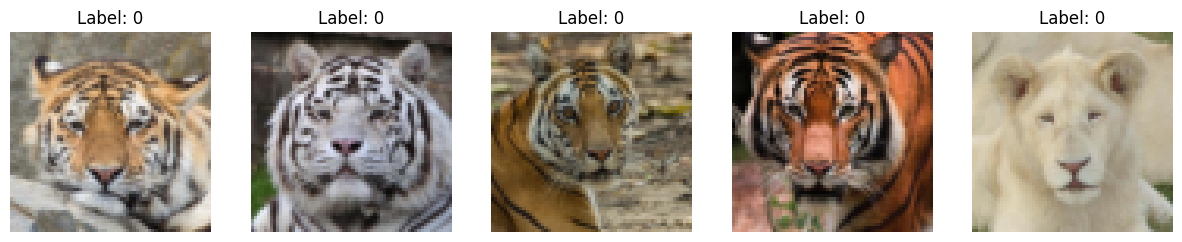

In [5]:
def show_random_images(dataset, class_names=None, num_images=5):
    plt.figure(figsize=(15,3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Change shape for plt.imshow
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(f"Label: {label}")
    plt.show()
    
show_random_images(train_dataset, num_images=5)

# **4. CNN Pré-entraîné sur la base ImageNet**
# Construction du Feature Extractor

Utiliser un CNN pré-entraîné comme extracteur de features, charger le modèle (VGG16, ResNet50..) avec `weights='imagenet'`, retirer la couche de classification (include_top=False). Le modèle doit être non entraînable(`trainable=False`)

# Extraction des descripteurs CNN
Générer pour chaque image un vecteur de caractéristiques

# Visualisation des Feature Maps
Comparer feature maps de différentes couches pour comprendre la hiérarchie des
représentations.

In [6]:
vgg_model = models.vgg16(weights='IMAGENET1K_V1').eval() 


# Créer l'extracteur avec les couches désirées
return_nodes = {
    'features.0':  'conv_early',   # premières convolutions (bords, textures)
    'features.15': 'conv_mid',     # profondeur intermédiaire
    'features.28': 'conv_deep',    # plus haut niveau
}

print(get_graph_node_names(vgg_model))

feature_extractor = create_feature_extractor(vgg_model, return_nodes=return_nodes)

feature_extractor.to(device)
feature_extractor.eval()

for param in feature_extractor.parameters():
    param.requires_grad = False


img, _ = train_dataset[2]

# Utilisation (retourne un dictionnaire)
with torch.no_grad():
    # to(device) pour utiliser le GPU si disponible
    img = img.to(device)
    features = feature_extractor(img.unsqueeze(0))
    ''' feats est un dict :
    # feats['conv_early'] : (1, C1, H1, W1)
    # feats['conv_mid']   : (1, C2, H2, W2)
    # feats['conv_deep']  : (1, C3, H3, W3) '''


(['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'], ['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'f

In [7]:
def show_feature_maps_from_layer(feats_dict, layer_key, num_maps=6):
    maps = feats_dict[layer_key][0]     # (C, H, W), on enlève le batch
    C = maps.shape[0]
    num_maps = min(num_maps, C)

    plt.figure(figsize=(3 * num_maps, 3))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i + 1)
        plt.imshow(maps[i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Feature maps - {layer_key}')
    plt.show()


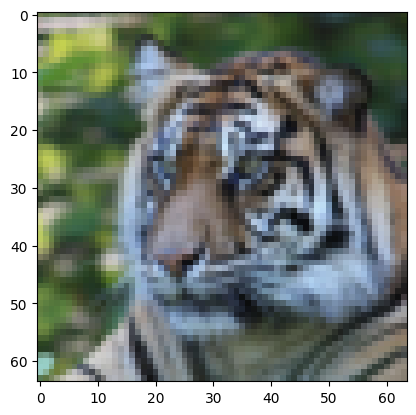

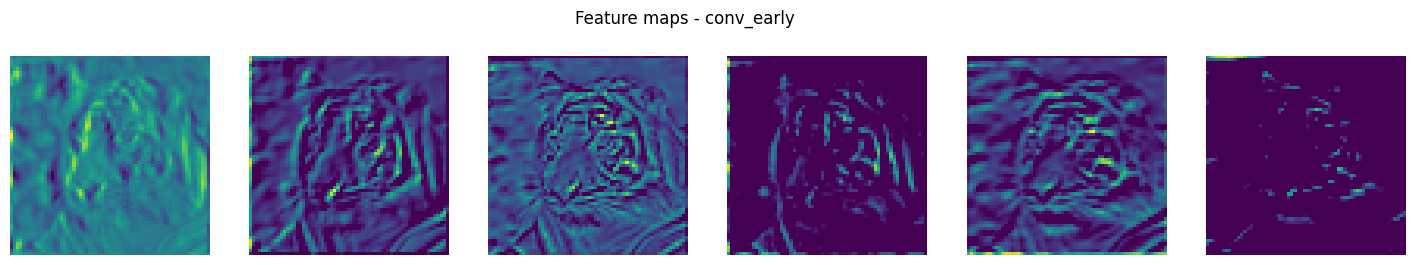

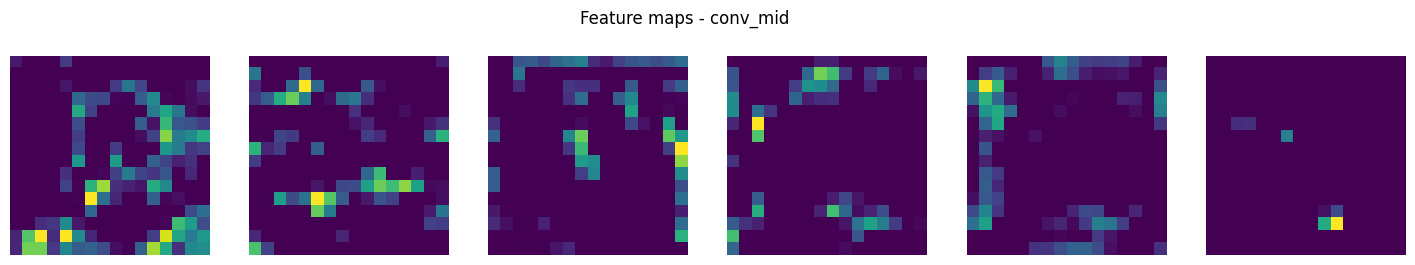

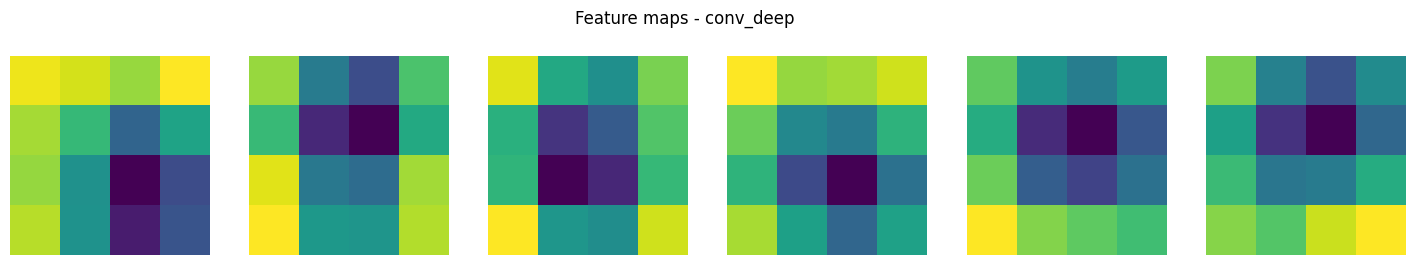

In [8]:
plt.imshow(img.cpu().permute(1, 2, 0))  # afficher l'image originale
show_feature_maps_from_layer(features, 'conv_early', num_maps=6)  # bords, textures
show_feature_maps_from_layer(features, 'conv_mid',   num_maps=6)  # motifs plus complexes
show_feature_maps_from_layer(features, 'conv_deep',  num_maps=6)  # parties / objets


* Première feature map : détecte des motifs très simples comme les bords, orientations et contrastes locaux (horizontal, vertical, coins), donc l’activation suit encore assez bien la structure « brute » de l’image.

* Feature map intermédiaire : combine plusieurs motifs bas niveau pour repérer des textures et formes plus complexes (motifs répétitifs, parties d’objets), avec une résolution spatiale déjà réduite et plus d’invariance aux petits déplacements.

* Dernière feature map : chaque canal code la présence de concepts très abstraits (parties d’objets ou quasi‑classes), sur une petite grille spatiale (par ex. 7×7), donc on vois des “pixels”, mais ce sont des scores d’activation très condensés qui résument l’image entière.

In [9]:
def extract_descriptors_VGG(dataloader, model, device, couche='conv_deep'):
    all_descriptors = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            out = model(imgs)
            # Utiliser les features de la couche 'conv_deep'
            feat_maps = out['conv_deep']  # (B, C, H, W)
            vecs = feat_maps.mean(dim=(2, 3))  # (B, C)

            all_descriptors.append(vecs.cpu())
            all_labels.append(labels)

    all_descriptors = torch.cat(all_descriptors, dim=0)  # (N, C)
    all_labels = torch.cat(all_labels, dim=0)            # (N,)

    return all_descriptors, all_labels

In [10]:
all_descriptors, _ = extract_descriptors_VGG(train_dataloader, feature_extractor, device)
print(all_descriptors.shape)  # N x dim_feature

torch.Size([3790, 512])


# **5. Autoencodeur profond**

# Build Autoencoder
- Encoder : plusieurs couches Conv2D + MaxPooling2D + Flatten + Dense(code_size)

- Decoder : Dense + Reshape + Conv2DTranspose pour reconstruire l'image

- Le modèle final prend une image en entrée et la reconstruit

In [11]:
class Encoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),    # (B, 64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (B, 64, 32, 32)

            nn.Conv2d(64, 128, 3, padding=1),  # (B, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (B, 128, 16, 16)

            nn.Conv2d(128, 256, 3, padding=1), # (B, 256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                   # (B, 256, 8, 8)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 8 * 8, code_size)  # 16384 → code_size

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        code = self.fc(x)
        return code


In [12]:
class Decoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.fc = nn.Linear(code_size, 256 * 8 * 8)

        self.deconv = nn.Sequential(
            # (B, 256, 8, 8) -> (B, 128, 16, 16)
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # (B, 128, 16, 16) -> (B, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (B, 64, 32, 32) -> (B, 3, 64, 64)
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, code):
        x = self.fc(code)
        x = x.view(-1, 256, 8, 8)
        x = self.deconv(x)
        return x


In [13]:
class Autoencoder(nn.Module):
    def __init__(self, code_size=128):
        super().__init__()
        self.encoder = Encoder(code_size)
        self.decoder = Decoder(code_size)

    def forward(self, x):
        code = self.encoder(x)
        recon = self.decoder(code)
        return recon, code

In [14]:
encoder = Encoder(code_size=128).to(device)
decoder = Decoder(code_size=128).to(device)

In [16]:
#Training the autoencoder
autoencoder = Autoencoder(code_size=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for imgs, _ in train_dataloader:  
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon, codes = autoencoder(imgs)
        loss = criterion(recon, imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - loss: {epoch_loss:.4f}")


Epoch 1/10 - loss: 0.0392
Epoch 2/10 - loss: 0.0266
Epoch 3/10 - loss: 0.0223
Epoch 4/10 - loss: 0.0198
Epoch 5/10 - loss: 0.0170
Epoch 6/10 - loss: 0.0155
Epoch 7/10 - loss: 0.0142
Epoch 8/10 - loss: 0.0133
Epoch 9/10 - loss: 0.0128
Epoch 10/10 - loss: 0.0120


In [17]:
autoencoder.eval()
test_loss = 0.0

with torch.no_grad():
    for imgs, _ in test_dataloader:
        imgs = imgs.to(device)
        recon, codes = autoencoder(imgs)
        loss = criterion(recon, imgs)
        test_loss += loss.item() * imgs.size(0)

test_loss = test_loss / len(test_dataloader.dataset)
print(f"Test reconstruction loss: {test_loss:.4f}")

Test reconstruction loss: 0.0121


# Extraction des descripteurs

In [ ]:
def extract_autoencoder_descriptors(dataloader, encoder, device):
    encoder.eval()
    all_codes = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)  
            codes = encoder(imgs)   
            all_codes.append(codes.cpu())
            all_labels.append(labels)

    all_codes = torch.cat(all_codes, dim=0)  
    all_labels = torch.cat(all_labels, dim=0) 
    return all_codes, all_labels

# Visualisation du vecteur latent de l’autoencodeur
- Comprendre ce que l'encodeur a appris pour représenter l'image

- Afficher le vecteur code latent produit par l'encodeur

- Comparer avec l'image reconstruite par le decoder

In [19]:
def show_pair(orig, rec):
    orig = orig.permute(1, 2, 0).detach().cpu().numpy()
    rec  = rec.permute(1, 2, 0).detach().cpu().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(orig); axs[0].axis('off'); axs[0].set_title("Original")
    axs[1].imshow(rec);  axs[1].axis('off'); axs[1].set_title("Reconstruit")
    plt.show()

In [20]:
autoencoder.eval()
imgs, _ = next(iter(train_dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    code_orig = autoencoder.encoder(imgs)
    recon = autoencoder.decoder(code_orig)
    code_recon = autoencoder.encoder(recon)
    
code_orig = code_orig[0].cpu()
code_recon = code_recon[0].cpu()

print(f"Code original shape: {code_orig.shape}")
print(f"Code reconstruction shape: {code_recon.shape}")

Code original shape: torch.Size([128])
Code reconstruction shape: torch.Size([128])


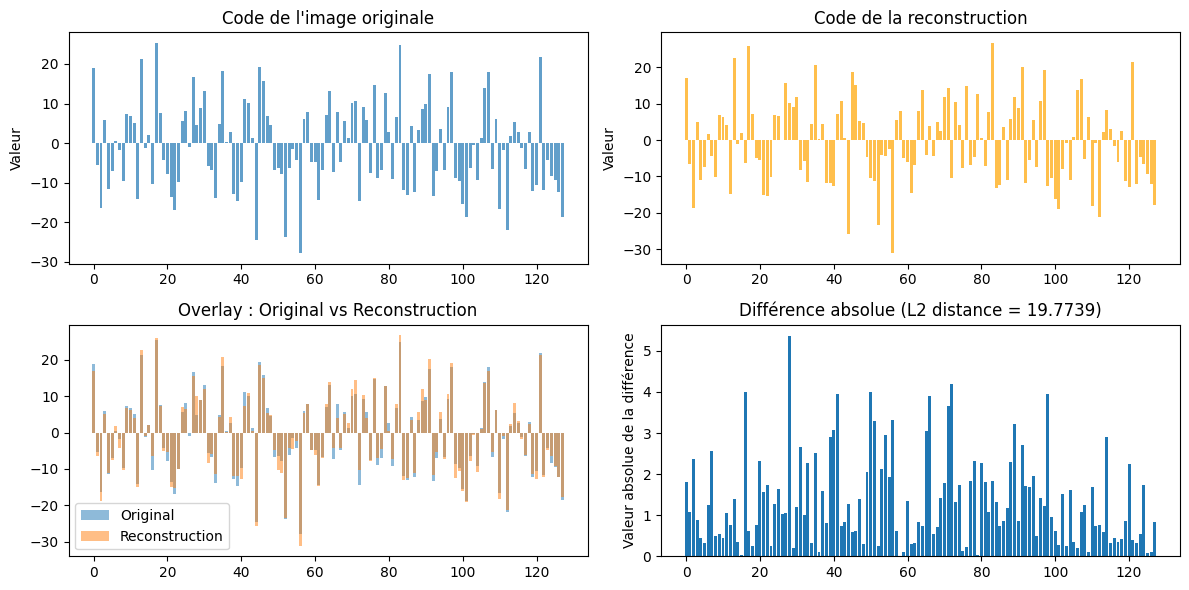

In [21]:
# Visualisation des codes
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Codes side-by-side
axes[0, 0].bar(range(len(code_orig)), code_orig.numpy(), alpha=0.7, label="Original")
axes[0, 0].set_title("Code de l'image originale")
axes[0, 0].set_ylabel("Valeur")

axes[0, 1].bar(range(len(code_recon)), code_recon.numpy(), alpha=0.7, label="Reconstruction", color='orange')
axes[0, 1].set_title("Code de la reconstruction")
axes[0, 1].set_ylabel("Valeur")

# Différence (overlay)
axes[1, 0].bar(range(len(code_orig)), code_orig.numpy(), alpha=0.5, label="Original")
axes[1, 0].bar(range(len(code_recon)), code_recon.numpy(), alpha=0.5, label="Reconstruction")
axes[1, 0].set_title("Overlay : Original vs Reconstruction")
axes[1, 0].legend()

# Distance entre les deux codes
distance = torch.norm(code_orig - code_recon).item()
diff = (code_orig - code_recon).abs()
axes[1, 1].bar(range(len(diff)), diff.numpy())
axes[1, 1].set_title(f"Différence absolue (L2 distance = {distance:.4f})")
axes[1, 1].set_ylabel("Valeur absolue de la différence")

plt.tight_layout()
plt.show()


In [22]:
print(code_orig.numpy())
print(code_recon.numpy())

[ 18.873032    -5.4436483  -16.318613     5.9193363  -11.474252
  -7.128958     0.5506548   -1.7284414   -9.663526     7.3179708
   6.7350435    5.196587   -14.168991    21.301165    -1.3422571
   1.9926789  -10.380384    25.33914      7.529706    -4.204605
  -7.7788568  -13.496489   -17.00996     -9.905286     5.647384
   8.199781    -1.027984    16.698465     4.7086205    8.835404
  13.099418    -5.6998696   -6.8522654  -13.746098     4.737724
  18.270317     0.36660728   2.7444677  -12.740558   -14.721259
  -9.685685    11.220131    10.07983      1.3623787  -24.46901
  19.301193    15.745883     6.7578235    4.527465    -6.797022
  -6.354866    -7.8449793  -23.686848    -6.2508245   -1.4414154
  -4.368735   -27.81217      5.995225     7.8607993   -4.743353
  -4.7410216  -14.322356    -6.664153     7.083644    13.120163
  -7.248446     7.8393626   -4.817189     5.7099133    1.1849291
  10.167004    10.737405   -14.541707     9.136454     5.7502756
  -7.5860577   14.739721    -8.80134

In [23]:
# Distance L2 (euclidienne)
l2_distance = torch.norm(code_orig - code_recon).item()

# Distance cosinus
cosine_sim = F.cosine_similarity(code_orig.unsqueeze(0), code_recon.unsqueeze(0)).item()

print(f"L2 distance: {l2_distance:.6f}")
print(f"Cosine similarity: {cosine_sim:.6f}")  # proche de 1.0 = très similaire


L2 distance: 19.773939
Cosine similarity: 0.988407


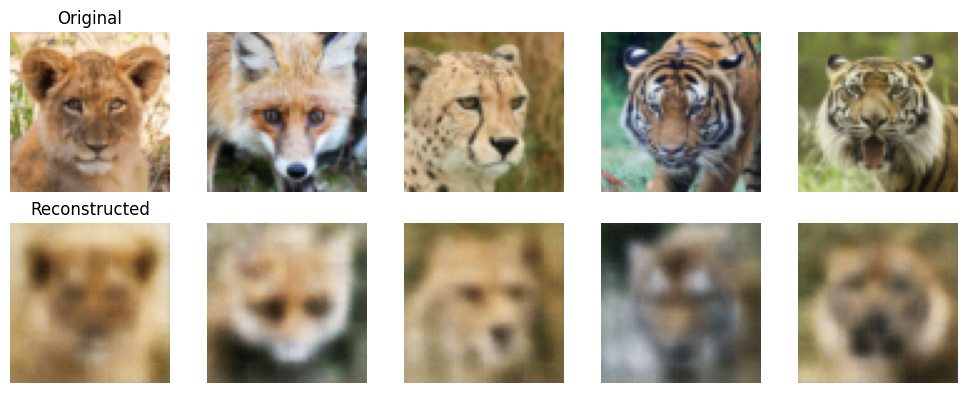

In [24]:
autoencoder.eval()
imgs, _ = next(iter(test_dataloader))
imgs = imgs.to(device)

with torch.no_grad():
    recon, codes = autoencoder(imgs)

imgs = imgs.cpu()
recon = recon.cpu()

n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    # original
    plt.subplot(2, n, i+1)
    plt.imshow(imgs[i].permute(1, 2, 0))
    plt.axis('off')
    if i == 0:
        plt.title("Original")

    # reconstruction
    plt.subplot(2, n, n+i+1)
    plt.imshow(recon[i].permute(1, 2, 0))
    plt.axis('off')
    if i == 0:
        plt.title("Reconstructed")
plt.tight_layout()
plt.show()

# **Recherche d’images similaires**

 - Comprendre comment utiliser les vecteurs descripteurs  pour rechercher des images proches dans une base.

- Comparer les performances de l’autoencodeur et du CNN pré-entraîné. Choisir la fonction distance ou similarité (cosine, distance euclidienne)

- Visualiser les résultats pour une image requête.

In [ ]:
descriptors_vgg_train, labels_train = extract_descriptors_VGG(train_dataloader, feature_extractor, device)
descriptors_vgg_test, labels_test = extract_descriptors_VGG(test_dataloader, feature_extractor, device)
print(f"VGG Descriptors - Train: {descriptors_vgg_train.shape}, Test: {descriptors_vgg_test.shape}")

VGG Descriptors - Train: torch.Size([3790, 512]), Test: torch.Size([948, 512])


In [26]:
desciptors_autoencoder_train, labels_train = extract_autoencoder_descriptors(train_dataloader, autoencoder.encoder, device)
desciptors_autoencoder_test, labels_test = extract_autoencoder_descriptors(test_dataloader, autoencoder.encoder, device)
print(f"Autoencoder Descriptors - Train: {desciptors_autoencoder_train.shape}, Test: {desciptors_autoencoder_test.shape}")

Autoencoder Descriptors - Train: torch.Size([3790, 128]), Test: torch.Size([948, 128])


In [27]:
def cosine_similarity_search(query_desc, database_desc, top_k=5):
    """
    Args:
        query_desc: (1, D) ou (D,)
        database_desc: (N, D)
        top_k: nombre de résultats
    Returns:
        indices: indices des top_k images les plus similaires
        similarities: similarités cosinus correspondantes
    """
    if query_desc.dim() == 1:
        query_desc = query_desc.unsqueeze(0)  # (1, D)
    
    # Similarité cosinus (plus proche de 1 = plus similaire)
    similarities = F.cosine_similarity(query_desc, database_desc, dim=1)  # (N,)
    
    # Top k
    top_similarities, top_indices = torch.topk(similarities, k=top_k)
    
    return top_indices, top_similarities

In [28]:
def euclidean_distance_search(query_desc, database_desc, top_k=5):
    """
    Distance euclidienne L2 (plus petite = plus similaire)
    """
    if query_desc.dim() == 1:
        query_desc = query_desc.unsqueeze(0)
    
    # Distance L2
    distances = torch.cdist(query_desc, database_desc, p=2).squeeze(0)  # (N,)
    
    # Top k (les plus petites distances)
    top_distances, top_indices = torch.topk(distances, k=top_k, largest=False)
    
    return top_indices, top_distances


In [29]:
def cbir_search(query_idx, database_desc, database_images, top_k=5, metric='cosine'):
    """
    Args:
        query_idx: index de l'image requête dans le dataset
        database_desc: descripteurs de la base (N, D)
        database_images: liste des images ou dataset
        top_k: nombre de résultats à retourner
        metric: 'cosine' ou 'euclidean'
    """
    query_desc = database_desc[query_idx]
    
    if metric == 'cosine':
        indices, scores = cosine_similarity_search(query_desc, database_desc, top_k=top_k+1)
    else:
        indices, scores = euclidean_distance_search(query_desc, database_desc, top_k=top_k+1)
    
    # Retirer la requête elle-même (premier résultat si requête dans la base)
    if indices[0] == query_idx:
        indices = indices[1:]
        scores = scores[1:]
    else:
        indices = indices[:top_k]
        scores = scores[:top_k]
    
    return indices, scores


def visualize_results(query_img, result_images, scores, metric='cosine'):
    """
    Affiche l'image requête + top résultats
    """
    n_results = len(result_images)
    plt.figure(figsize=(15, 3))
    
    # Image requête
    plt.subplot(1, n_results + 1, 1)
    if isinstance(query_img, torch.Tensor):
        query_img = query_img.permute(1, 2, 0).numpy()
    plt.imshow(query_img)
    plt.title("Query", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Résultats
    for i, (img, score) in enumerate(zip(result_images, scores)):
        plt.subplot(1, n_results + 1, i + 2)
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        plt.imshow(img)
        
        if metric == 'cosine':
            plt.title(f"Sim: {score:.3f}", fontsize=10)
        else:
            plt.title(f"Dist: {score:.3f}", fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


=== VGG16 Results (Cosine Similarity) ===


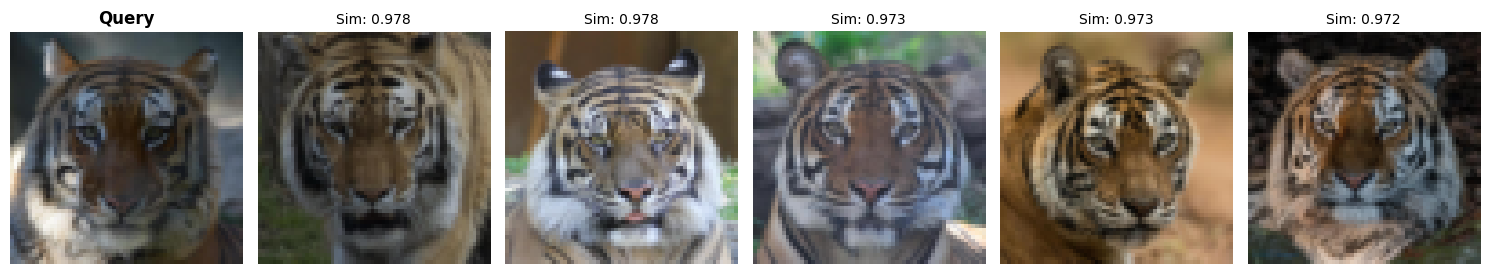

=== Autoencoder Results (Cosine Similarity) ===


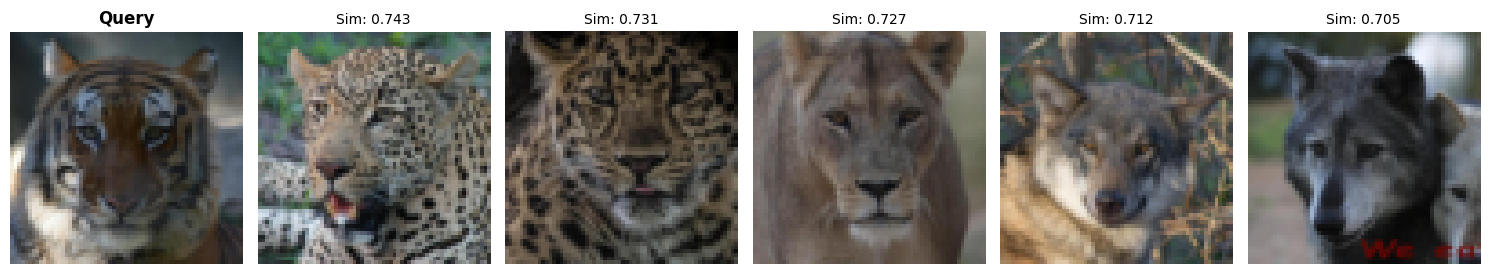

=== Autoencoder Results (L2 Distance) ===


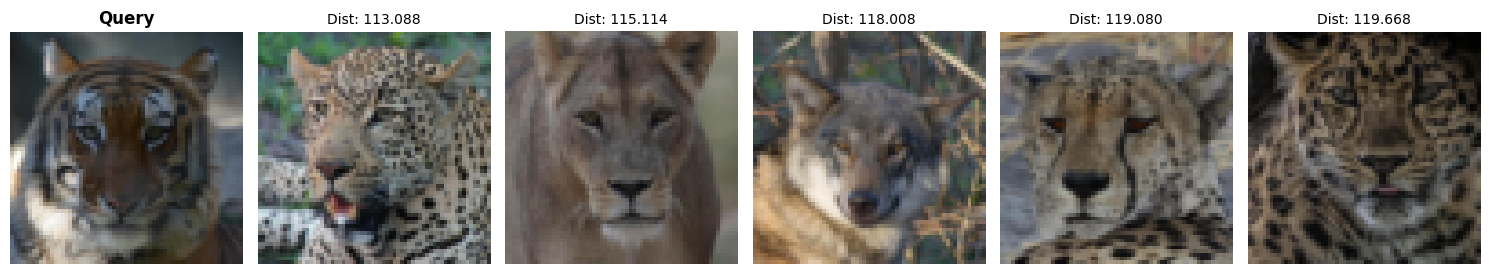

In [ ]:
query_idx = 10  # index dans le test dataset

query_img, _ = test_dataset[query_idx]

# --- Recherche avec VGG (cosine) ---
indices_vgg, scores_vgg = cbir_search(
    query_idx, 
    descriptors_vgg_test, 
    test_dataset, 
    top_k=5, 
    metric='cosine'
)

result_images_vgg = [test_dataset[idx][0] for idx in indices_vgg]

print("=== VGG16 Results (Cosine Similarity) ===")
visualize_results(query_img, result_images_vgg, scores_vgg, metric='cosine')


# --- Recherche avec Autoencodeur (cosine) ---
indices_ae, scores_ae = cbir_search(
    query_idx,
    desciptors_autoencoder_test,
    test_dataset,
    top_k=5,
    metric='cosine'
)

result_images_ae = [test_dataset[idx][0] for idx in indices_ae]

print("=== Autoencoder Results (Cosine Similarity) ===")
visualize_results(query_img, result_images_ae, scores_ae, metric='cosine')


# --- Comparaison avec distance euclidienne ---
indices_ae_l2, scores_ae_l2 = cbir_search(
    query_idx,
    desciptors_autoencoder_test,
    test_dataset,
    top_k=5,
    metric='euclidean'
)

result_images_ae_l2 = [test_dataset[idx][0] for idx in indices_ae_l2]

print("=== Autoencoder Results (L2 Distance) ===")
visualize_results(query_img, result_images_ae_l2, scores_ae_l2, metric='euclidean')
